<a href="https://colab.research.google.com/github/aashrithresearch/Intracranial-Aneurysm-Detector/blob/main/intracranial_aneurysm_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
try:
    import google.colab
    %pip install fastMONAI --quiet
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

################################################################################
Remember to attach a GPU to your Colab Runtime:
1. From the **Runtime** menu select **Change Runtime Type**
2. Choose **GPU** from the drop-down menu
3. Click **'SAVE'**
################################################################################


In [101]:
from fastMONAI.vision_all import *

In [92]:
df_train_val, df_test = download_medmnist3d_dataset(study='VesselMNIST3D', max_workers=2)

In [93]:
df_test.head()

,img_path,labels,is_val
0,../data/VesselMNIST3D/test_images/0_nodule.nii.gz,1,False
1,../data/VesselMNIST3D/test_images/1_nodule.nii.gz,1,False
2,../data/VesselMNIST3D/test_images/2_nodule.nii.gz,1,False
3,../data/VesselMNIST3D/test_images/3_nodule.nii.gz,1,False
4,../data/VesselMNIST3D/test_images/4_nodule.nii.gz,1,False


In [94]:
dls = MedImageDataLoaders.from_df(df_train_val, fn_col='img_path', label_col='labels',
                                  splitter=ColSplitter('is_val'), item_tfms=Resize(460), batch_tfms=aug_transforms(size=128, pad_mode='zeros', min_scale=0.75),
                                  resample=1, bs=64)

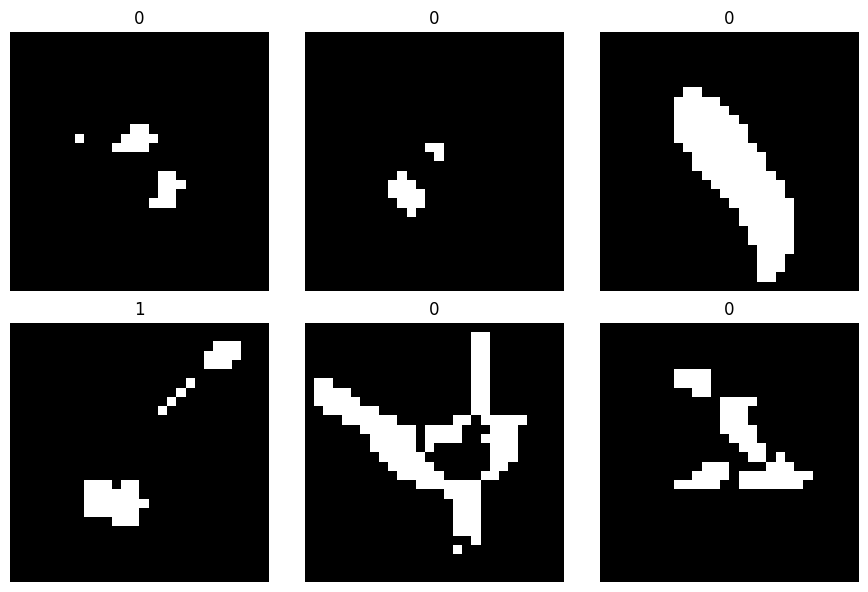

In [69]:
dls.show_batch(nrows=2, ncols=3)

In [86]:
from monai.networks.nets import Classifier

in_shape = [1, 28, 28, 28]

model_3d = Classifier(in_shape=in_shape, classes=2,
                   channels=(8, 16, 32, 64), strides=(2, 2, 2))

In [71]:
learn = Learner(dls, model_3d, metrics=accuracy)
learn.summary()

Classifier (Input shape: 64 x 1 x 28 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 14 x 14 x  
Conv3d                                    224        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    1736       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    224        True      
____________________________________________________________________________
                     64 x 16 x 7 x 7 x 7 
Conv3d                                    3472       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d         

In [77]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.017436,2.159615,0.862295,00:21


epoch,train_loss,valid_loss,accuracy,time
0,0.014623,1.947354,0.862295,00:21
1,0.006646,1.971902,0.872131,00:22
2,0.006518,2.071830,0.865574,00:20
3,0.012902,2.188388,0.865574,00:22
4,0.019462,1.929272,0.885246,00:23
5,0.018668,1.821713,0.895082,00:25
6,0.012673,1.805177,0.898361,00:24
7,0.008524,1.808643,0.901639,00:22


In [79]:
learn3d = Learner(dls, model_3d, metrics=accuracy)

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


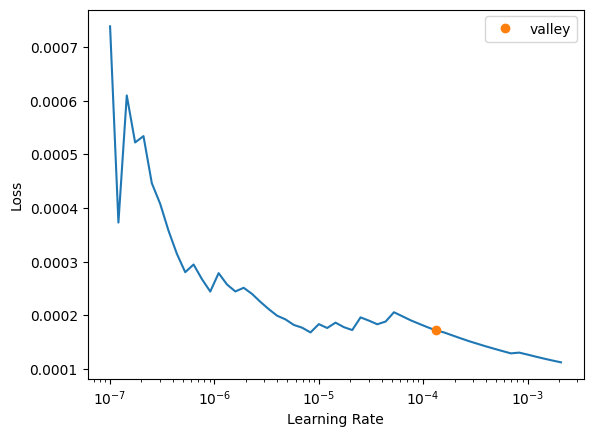

In [80]:
lr = learn3d.lr_find()

In [81]:
learn3d.fine_tune(8, lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.000186,1.838069,0.898361,00:25


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


epoch,train_loss,valid_loss,accuracy,time
0,0.000016,1.839430,0.895082,00:21
1,0.000009,1.843010,0.895082,00:22
2,0.000006,1.848125,0.895082,00:25
3,0.000004,1.851856,0.895082,00:23
4,0.000003,1.852891,0.895082,00:24
5,0.000002,1.854380,0.895082,00:22
6,0.000002,1.854837,0.895082,00:22
7,0.000001,1.854880,0.895082,00:25


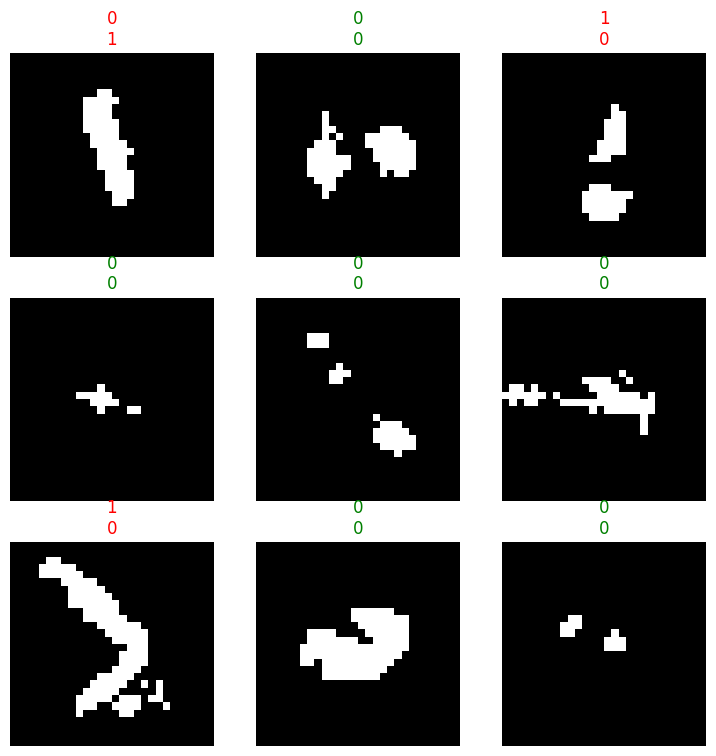

In [82]:
learn.show_results()

In [95]:
from fastMONAI.dataset_info import MedDataset

med_dataset = MedDataset(img_list=df_train_val.img_path.tolist(), max_workers=12)
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In [96]:
store_variables(pkl_fn='vars.pkl', size=in_shape, reorder=reorder,  resample=resample)

In [97]:
learn.export('aneurysm.pkl')

In [98]:
learn = load_learner('aneurysm.pkl', cpu=True)
_, reorder, resample = load_variables(pkl_fn='vars.pkl')

In [99]:
import gradio as gr

gr.Interface(fn=lambda fileobj: gradio_image_classifier(fileobj, learn,
                                                        reorder, resample),
             inputs=['file'],
             outputs=gr.Label(num_top_classes=2),
             examples=[df_test.img_path[0], df_test.img_path[200]],
             title='Brain Vessel Intracranial Aneurysm Detector (1 = healthy, 0 = aneurysm)').launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c946a9fbe8571fd3ea.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
